In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [3]:
import torch
from torch.nn.functional import grid_sample
from deepshape.curves import *

In [4]:
from scipy.ndimage import gaussian_filter1d

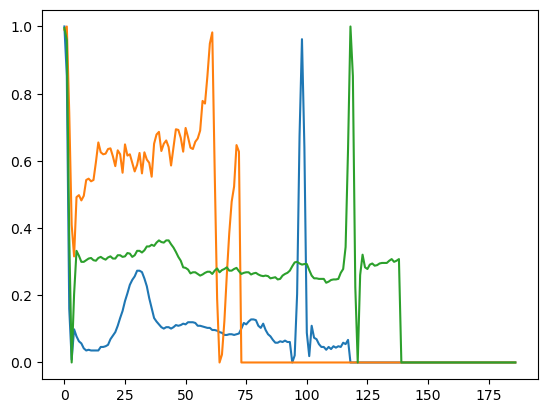

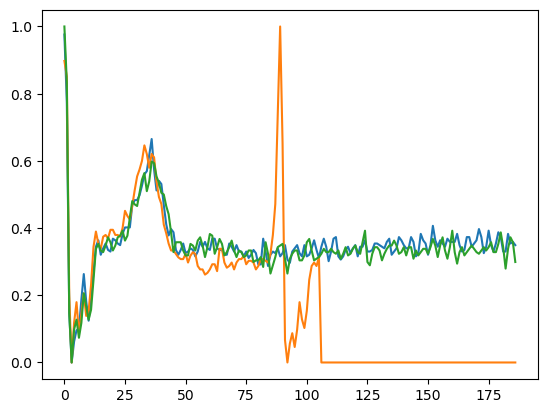

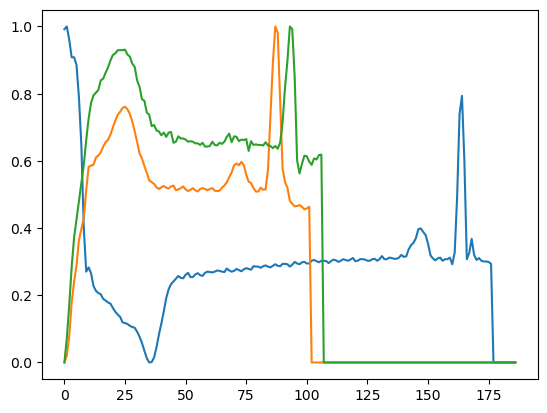

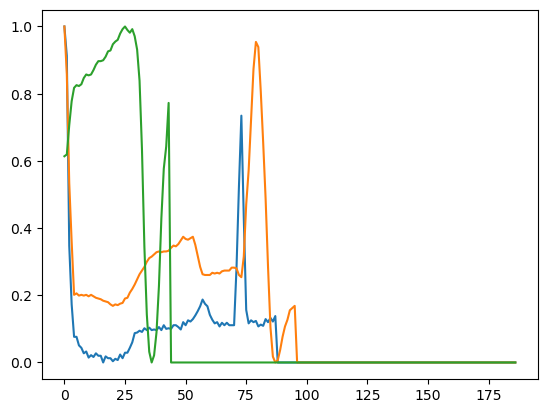

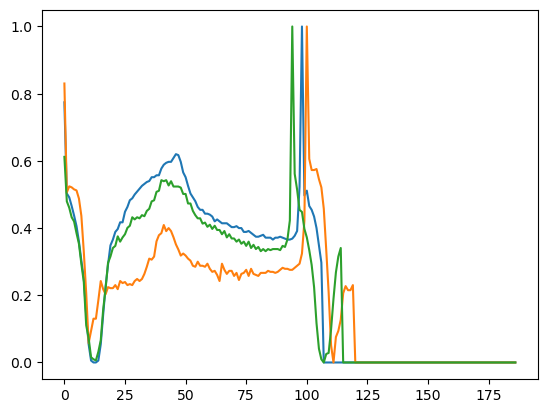

In [5]:
datapath = '../data/mitbih_train.csv'

df = pd.read_csv(datapath, header=None)
df, labels = df.iloc[:, :-1], df.iloc[:, -1].astype(int)

for i in np.unique(labels):
    plt.figure()
    plt.plot(df.where(labels == i).dropna().sample(3).transpose())
    
plt.show()

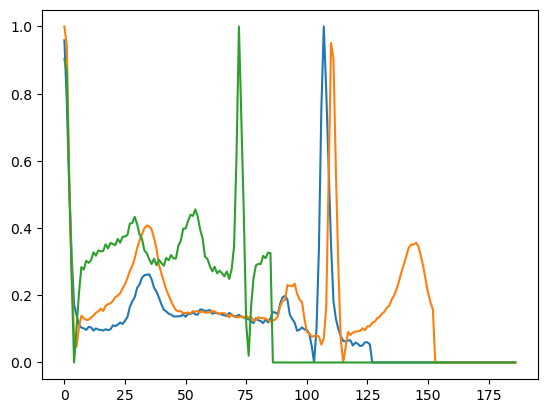

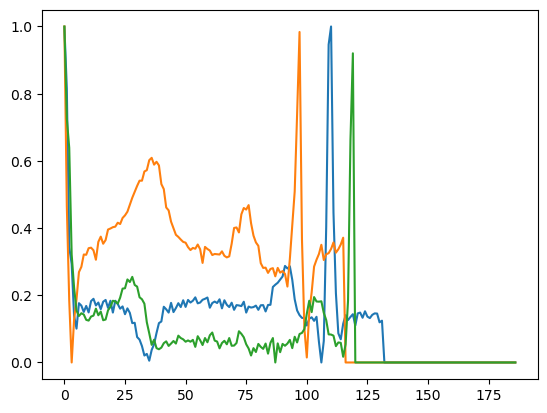

In [6]:
datapath = '../data/ptbdb_normal.csv'
dfn = pd.read_csv(datapath, header=None)
dfn, labels = dfn.iloc[:, :-1], dfn.iloc[:, -1].astype(int)
plt.plot(dfn.sample(3).transpose())
plt.show()

datapath = '../data/ptbdb_abnormal.csv'
dfabn = pd.read_csv(datapath, header=None)
dfabn, labels = dfabn.iloc[:, :-1], dfabn.iloc[:, -1].astype(int)
plt.plot(dfabn.sample(3).transpose())
plt.show()

In [321]:
m = torch.nn.Conv1d(1, 1, 10)

In [325]:
df = central_differences(f, x)
plt.plot(df)

In [88]:
class FuncApprox:
    def __init__(self, data):
        self.data = torch.zeros(1, 1, 1, data.shape[0])
        self.data[0, 0, 0, :] = data.squeeze()
        
    def __call__(self, x):
        grid = torch.zeros(1, 1, x.shape[0], 2)
        grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return grid_sample(self.data, grid, padding_mode='border', align_corners=False,
                           mode='bicubic').reshape(-1, 1)
    
    def _create_grid(self, x):
        if self.grid.shape[2] != x.view(-1).shape[0]:
            self.grid = torch.zeros(1, 1, x.shape[0], 2)
        self.grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return self.grid
    

class FunctionalQmap:
    def __init__(self, f: FuncApprox):
        self.f = f
        self.m = torch.
        
    def __call__(self, x, h=1e-4):
        Df = central_differences(self.f, x, h)
#         return torch.sqrt(torch.abs(Df)+1e-8) * self.f(x)
        return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)
#         return torch.sign(Df) * torch.sqrt(torch.abs(Df) + 1e-8) * self.f(x)

def get_ecg_curve(df, idx, sigma=1.5, remove_trailing_zeros=True):
    if type(df) is pd.DataFrame:
        df  = df.to_numpy()
        
    y = torch.tensor(df[idx], dtype=torch.float32)
    if remove_trailing_zeros:
        y = y[torch.nonzero(y, as_tuple=False)]
        
    if sigma > 0.:
        y = gaussian_filter1d(y.squeeze(), sigma=sigma)
        return torch.tensor(y).reshape(-1, 1)
    return y.reshape(-1, 1)

In [336]:
from scipy.interpolate import interp1d

In [342]:
xd = np.linspace(0, 1, d.shape[0])

In [353]:
f = interp1d(xd, d.numpy().squeeze(), kind='cubic', fill_value='extrapolate')

In [358]:
f(xd)

array([1.        , 0.90032417, 0.35858995, 0.05145867, 0.04659643,
       0.12682334, 0.13330632, 0.1191248 , 0.11061589, 0.113047  ,
       0.10656402, 0.10696921, 0.11588331, 0.12236629, 0.12236629,
       0.11952998, 0.11588331, 0.12236629, 0.12601297, 0.1337115 ,
       0.13492706, 0.14262562, 0.15113452, 0.15842788, 0.16369531,
       0.17382497, 0.18881686, 0.20786062, 0.23095624, 0.25850892,
       0.29457051, 0.32576984, 0.36264181, 0.3982982 , 0.42949757,
       0.4493517 , 0.45097244, 0.41896272, 0.37277147, 0.31037277,
       0.25      , 0.20421393, 0.16896272, 0.14748785, 0.13047002,
       0.12439222, 0.11750405, 0.11669368, 0.11588331, 0.11871961,
       0.11547812, 0.11385737, 0.11952998, 0.11669368, 0.12277147,
       0.12074554, 0.11669368, 0.12277147, 0.12641816, 0.13168557,
       0.14181523, 0.13938412, 0.14505672, 0.14343598, 0.14100486,
       0.14059968, 0.13816856, 0.136953  , 0.13209076, 0.12844409,
       0.12844409, 0.1280389 , 0.1252026 , 0.12236629, 0.11709

In [355]:
(f(x+h) - f(x-h))

array([[ 9.54700211e-03],
       [ 2.87438078e-03],
       [-2.68641418e-03],
       [-7.13537573e-03],
       [-1.04725172e-02],
       [-1.26978358e-02],
       [-1.38113315e-02],
       [-1.38130043e-02],
       [-1.27028541e-02],
       [-1.06595274e-02],
       [-8.55017519e-03],
       [-6.49102126e-03],
       [-4.48206560e-03],
       [-2.54037856e-03],
       [-8.89249116e-04],
       [ 4.01741831e-04],
       [ 1.33260704e-03],
       [ 1.90385734e-03],
       [ 2.16470907e-03],
       [ 2.14817691e-03],
       [ 1.85426087e-03],
       [ 1.28296093e-03],
       [ 6.11957131e-04],
       [ 1.14263370e-04],
       [-2.06884393e-04],
       [-3.51486156e-04],
       [-3.57472985e-04],
       [-3.50097077e-04],
       [-3.39376861e-04],
       [-3.25312336e-04],
       [-3.05864876e-04],
       [-2.65267620e-04],
       [-2.00170652e-04],
       [-1.10573971e-04],
       [ 1.57115881e-06],
       [ 8.08623634e-05],
       [ 1.01694949e-04],
       [ 6.40689169e-05],
       [-3.2

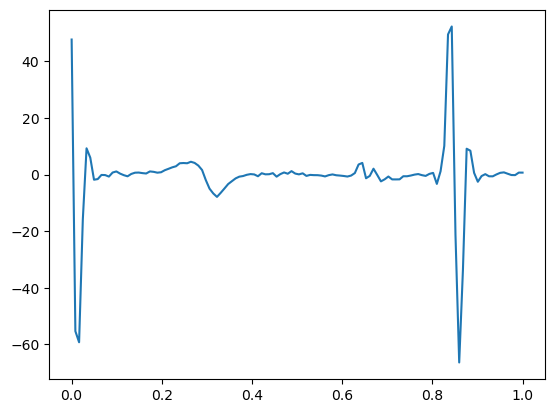

In [360]:
h = 1e-4
# plt.plot(xd, d)
# plt.plot(xd, f(xd), '--')
plt.plot(xd, 0.5 / h * (f(xd+h) - f(xd-h)))
plt.show()

In [377]:
N = 1
R = torch.zeros(1 + 2 * N)
freq = torch.arange(1, N+1)
diag = 8 * pi ** 4 * torch.cat((torch.zeros(1), freq, freq))

R = torch.diag(diag)
R

tensor([[  0.0000,   0.0000,   0.0000],
        [  0.0000, 779.2727,   0.0000],
        [  0.0000,   0.0000, 779.2727]])

In [498]:


class RBFApprox:
    def __init__(self, y: torch.Tensor, N: int):
        Xtr = col_linspace(0, 1, y.view(-1).shape[0])
        self.N = N
        self.lenparam = 1. / N
        self.nodes = torch.linspace(-2 * self.lenparam, 1. + 2 * self.lenparam, N + 4)
        
        self.penalty = 0.
        self.find_weights(Xtr, y)

    def eval_basis(self, x):
        return torch.cat([torch.ones_like(x), torch.exp(-(x - self.nodes)**2 / self.lenparam**2)], dim=1)
        return torch.exp(-(x - self.nodes)**2 / self.lenparam**2)


    def __call__(self, x):
        B = self.eval_basis(x)
        return torch.mm(B, self.w)

    def find_weights(self, Xtr, y):
        B = self.eval_basis(Xtr)
        R = torch.eye(y.shape[0])
        print(B.shape)
        print(y.shape)
        w = np.linalg.solve((torch.mm(B.t(), B)).numpy(),
                            torch.mm(B.t(), y).numpy())

        self.w = torch.Tensor(w)

torch.Size([100, 35])
torch.Size([100, 1])


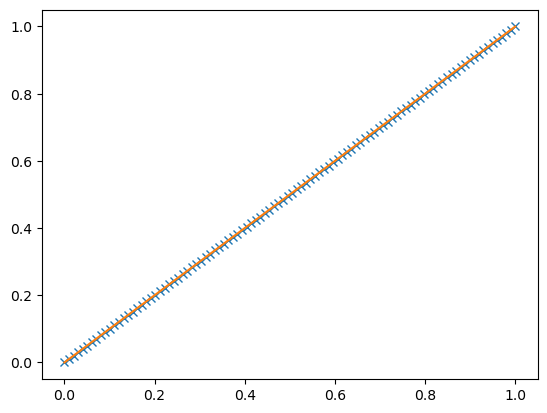

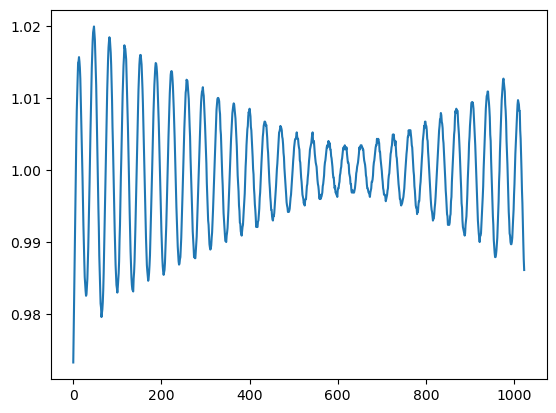

In [499]:
N = 30
k = 100

y = col_linspace(0, 1, k)
f = RBFApprox(y, N)
x = col_linspace(0, 1, 1024)

plt.plot(y, y, 'x')
plt.plot(x, f(x))
plt.show()

x = col_linspace(0, 1, 1024)
plt.plot(central_differences(f, x, 1e-4))
plt.show()

In [376]:

# d = get_ecg_curve(dfn, 0, sigma=0., remove_trailing_zeros=True)
f = RBFApprox(y, 10)

x = col_linspace(0, 1, 2048)
plt.plot(col_linspace(0, 1, y.shape[0]), y, 'x', label='data')
plt.plot(x, f(x), label='approx')
plt.legend()
plt.show()

# q = FunctionalQmap(f)
# plt.plot(q(x))
# plt.show()


# plt.plot(central_differences(f, x))
# plt.show()

torch.Size([6, 10])
torch.Size([6, 1])


ValueError: x and y must have same first dimension, but have shapes torch.Size([2048, 1]) and torch.Size([6, 1])

In [370]:
class FourierApprox:
    def __init__(self, y: torch.Tensor, N: int, penalty: float = 0.):
        Xtr = col_linspace(0, 1, y.view(-1).shape[0])
        self.N = N
        self.dim = 1 + 2*N
        self.freqvec = torch.arange(1, N+1) * 2.0 * pi
        self.penalty = penalty
        self.find_weights(Xtr, y)

    def eval_basis(self, x):
        T = self.freqvec * x
        B = torch.cat([torch.ones_like(x), sin(T), cos(T)], dim=1)
        return B
    
    def eval_penalty_matrix(self, x):
        R = torch.zeros(1 + 2 * self.N)
        freq = torch.arange(1, self.N + 1)
        diag = 8 * pi ** 4 * torch.cat((torch.zeros(1), freq, freq))
        return torch.diag(diag)

    def __call__(self, x):
        B = self.eval_basis(x)
        return torch.mm(B, self.w)

    def find_weights(self, x, y):
        B = self.eval_basis(x)
        R = self.eval_penalty_matrix(x)
        print(B.shape, R.shape)
        w = np.linalg.solve((torch.mm(B.t(), B) + self.penalty * R).numpy(),
                            torch.mm(B.t(), y).numpy())
        self.w = torch.Tensor(w)


torch.Size([122, 201]) torch.Size([201, 201])


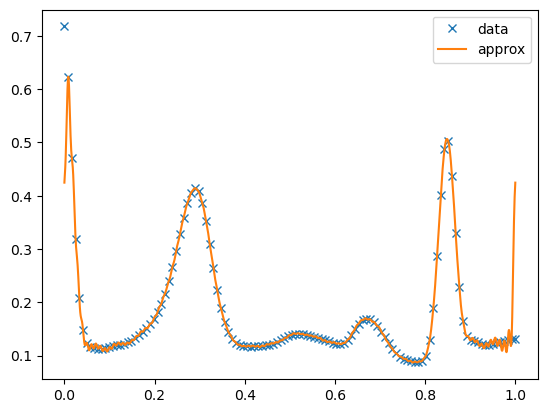

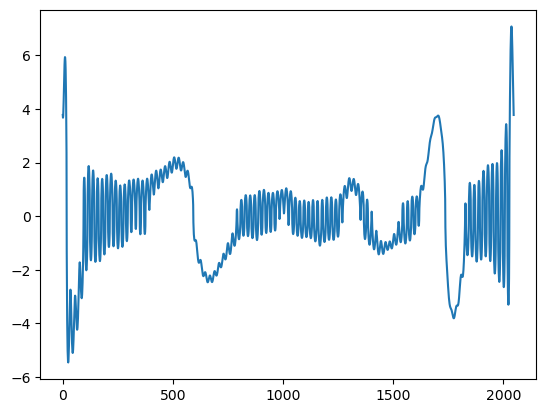

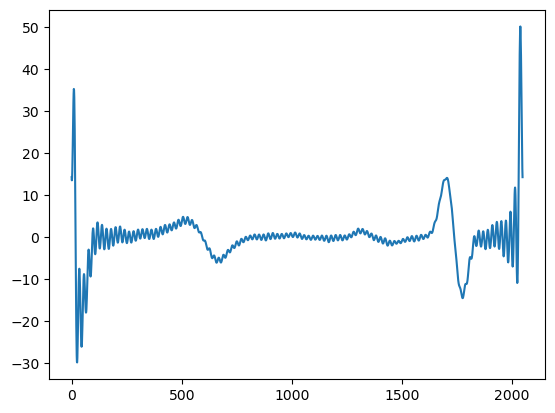

In [513]:
d = get_ecg_curve(dfn, 0, sigma=2., remove_trailing_zeros=True)
f = FourierApprox(d, 100, penalty=1e-6)
# f = RBFApprox(d, 100)

x = col_linspace(0, 1, 2048)
plt.plot(col_linspace(0, 1, d.shape[0]), d, 'x', label='data')
plt.plot(x, f(x), label='approx')
plt.legend()
plt.show()

q = FunctionalQmap(f)
plt.plot(q(x))
plt.show()


plt.plot(central_differences(f, x))
plt.show()

[Iter     1] loss: 3.880136
[Iter     6] loss: 2.297211
[Iter    11] loss: 2.109591
[Iter    16] loss: 2.023874
[Iter    21] loss: 1.975353
[Iter    26] loss: 1.888369
[Iter    31] loss: 1.840137
[Iter    36] loss: 1.725173
[Iter    41] loss: 1.701372
[Iter    46] loss: 1.689859
[Iter    51] loss: 1.682782
[Iter    56] loss: 1.679718
[Iter    61] loss: 1.690844
[Iter    66] loss: 1.677115
[Iter    71] loss: 1.675904
[Iter    76] loss: 1.674833
[Iter    81] loss: 1.673288

Finished training in 0.64706s


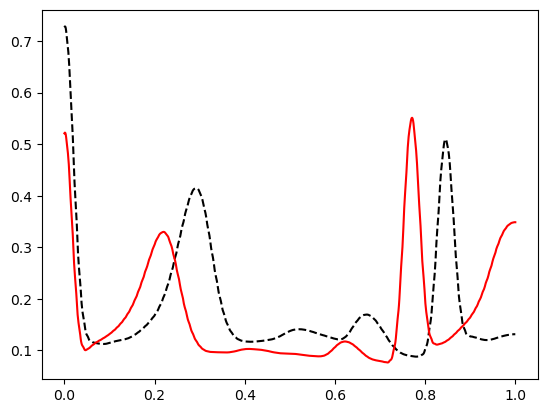

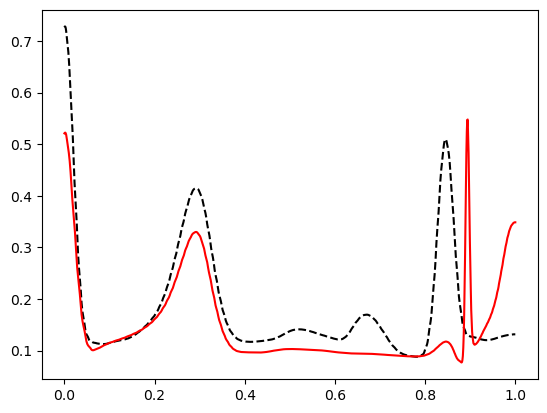

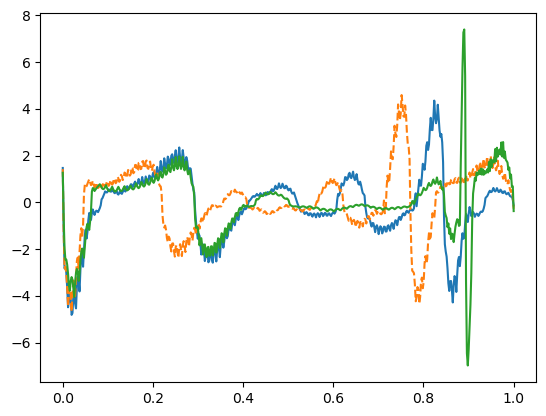

In [327]:
def reparametrize_and_plot(g1, g2):
    q = FunctionalQmap(g1)
    r = FunctionalQmap(g2)
    loss = CurveDistance(q, r, 512, h=1e-2)

    RN = CurveReparametrizer([
        SineSeries(10) for _ in range(10)
    ])

    optimizer = torch.optim.LBFGS(RN.parameters(), lr=0.5, max_iter=100, line_search_fn='strong_wolfe')
    log = Logger(5)

    error = reparametrize(RN, loss, optimizer, 200, log)
    
    x = col_linspace(0, 1, 1024)
    with torch.no_grad():
        
        plt.figure()
        plt.plot(x, g1(x), '--', c='k')
        plt.plot(x, g2(x),  c='r')
        
        plt.figure()
        plt.plot(x, g1(x), ls='--', c='k')
        plt.plot(x, g2(RN(x)), c='r')
    
    for p in RN.parameters():
        p.requires_grad = False
    return RN

        
d1 = get_ecg_curve(dfn, 0, sigma=2., remove_trailing_zeros=True)
f1 = FuncApprox(d1)

d2 = get_ecg_curve(dfn, 5, sigma=2., remove_trailing_zeros=True)
f2 = FuncApprox(d2)
rn = reparametrize_and_plot(f1, f2)
plt.show()

q, r = FunctionalQmap(f1), FunctionalQmap(f2)
x = col_linspace(0, 1, 512)
plt.plot(x, q(x))
plt.plot(x, r(x), '--')
plt.plot(x, torch.sqrt(rn.derivative(x)) * r(rn(x)))

plt.show()

[Iter     1] loss: 2.939747
[Iter     6] loss: 0.610407
[Iter    11] loss: 1.869777
[Iter    16] loss: 0.562782
[Iter    21] loss: 0.521150
[Iter    26] loss: 0.516984
[Iter    31] loss: 0.514290
[Iter    36] loss: 0.512659
[Iter    41] loss: 0.504443
[Iter    46] loss: 0.495971
[Iter    51] loss: 0.494943
[Iter    56] loss: 0.494093
[Iter    61] loss: 0.493386
[Iter    66] loss: 0.493047
[Iter    71] loss: 0.492942

Finished training in 0.53396s


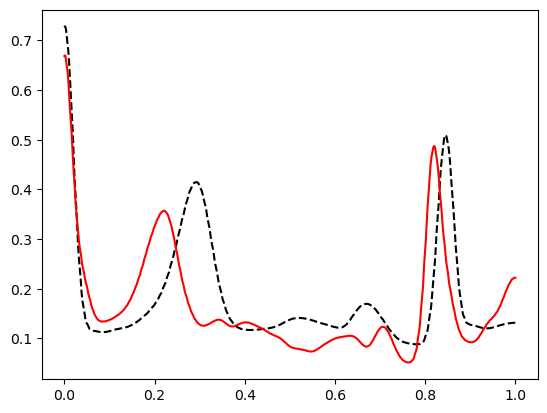

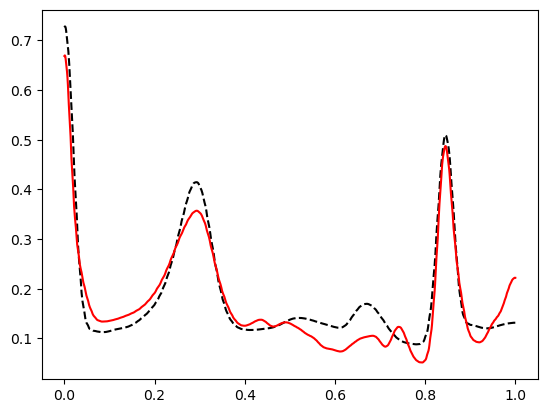

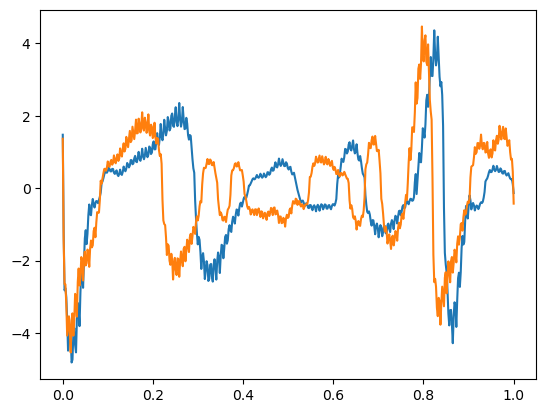

In [328]:
d1 = get_ecg_curve(dfn, 0, sigma=2., remove_trailing_zeros=True)
f1 = FuncApprox(d1)

d2 = get_ecg_curve(dfabn, 1, sigma=2., remove_trailing_zeros=True)
f2 = FuncApprox(d2)
reparametrize_and_plot(f1, f2)
plt.show()

q, r = FunctionalQmap(f1), FunctionalQmap(f2)
x = col_linspace(0, 1, 512)
plt.plot(x, q(x))
plt.plot(x, r(x))
plt.show()